🚀 Starting the Enhanced O2D Promise Optimization Script with Target Percentages...

📋 Configuration Summary:
  🎯 Target Distribution:
    - 1 Day BP: 18.0%
    - At least 2 Day BP: 2.0%
    - Breach: 4.0%
    - On Promise: 75.0%
  🔧 Optimization Weights:
    - 1_Day_BP Weight: 0.3
    - 2_Day_BP Weight: 0.1
    - Breach Penalty: 3.0
    - On Promise Weight: 0.5
  ⚙️ Fallback Max Breach: 5.0%
  🔁 Max Iterations: 50, Tolerance: 0.5%
  📅 Max O2D Promise to test: 7 days

🔄 STEP 1 & 2: LOADING & PREPARING DATA
📂 Loading data from: C:\Users\adity\OneDrive\Desktop\TATACLiQ Data\ModelData\sample.xlsx
✅ Data loaded successfully!
   📊 Total records: 17,808
   📊 Columns found: 25
   📊 Key columns present: p1slaveid, seller_city, o2s_p, o2s_a, s2d_p, s2d_a

🔍 Processing O2D delivery promise and actual calculations...
🔍 Processing O2D delivery status calculations...
✅ Status calculation complete:
   📊 Records before cleaning: 17,808
   📊 Records after cleaning: 17,640
   📊 Records removed: 168

🛣️ 

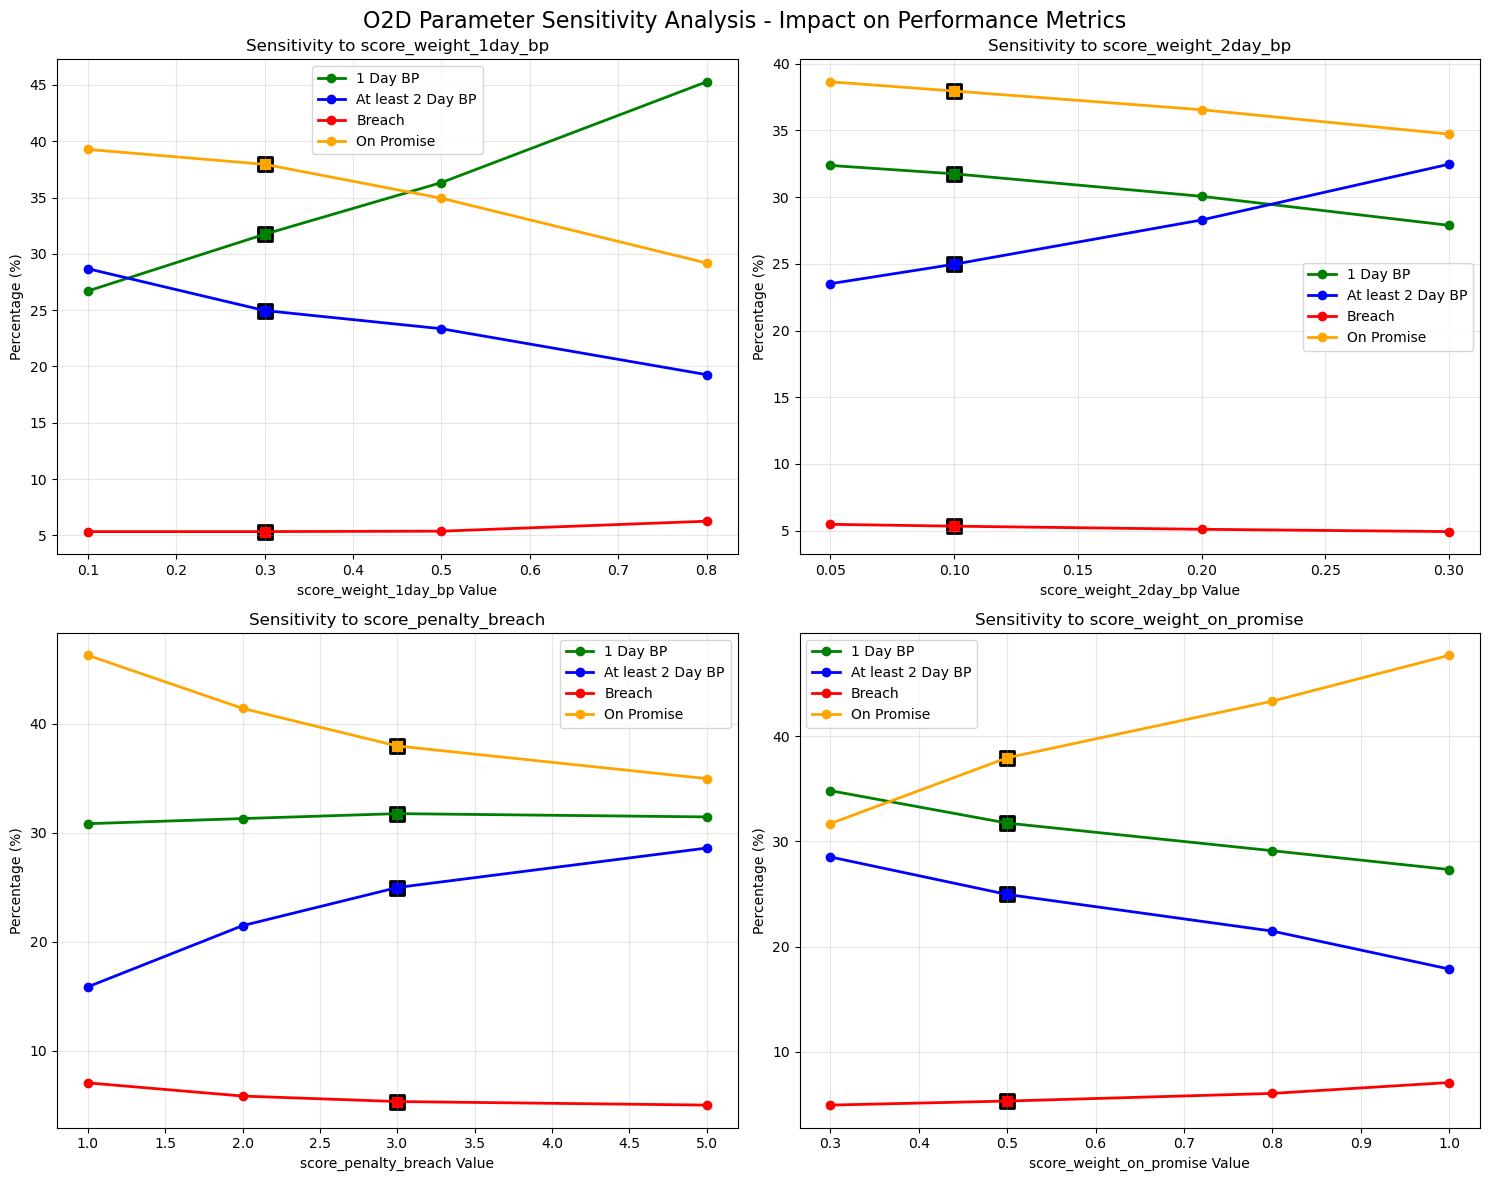

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Record start time
start_time = time.time()

print("🚀 Starting the Enhanced O2D Promise Optimization Script with Target Percentages...")

# ============ USER CONFIGURATION ============
file_path = "C:\\Users\\adity\\OneDrive\\Desktop\\TATACLiQ Data\\ModelData\\sample.xlsx" #<-- Use your full data file

# --- STRATEGIC TARGETS (O2D Specific) ---
target_percentages = {
    '1 Day BP': 18.0,
    'At least 2 Day BP': 2.0,
    'Breach': 4.0,
    'On Promise': 75.0
}

max_breach = 5.0          # Fallback constraint if target approach doesn't work

# --- STRATEGIC TUNING PARAMETERS ---
score_weight_1day_bp = 0.3
score_weight_2day_bp = 0.1
score_penalty_breach = 3.0
score_weight_on_promise = 0.5  # Higher weight to favor 'On Promise'

# Additional parameters for target-based optimization
max_iterations = 50
tolerance = 0.5

# O2D Promise upper bounds (equivalent to lane_tat_limits)
max_o2d_p_promise = 7

print("\n📋 Configuration Summary:")
print("=" * 60)
print(f"  🎯 Target Distribution:")
for status, target in target_percentages.items():
    print(f"    - {status}: {target}%")
print(f"  🔧 Optimization Weights:")
print(f"    - 1_Day_BP Weight: {score_weight_1day_bp}")
print(f"    - 2_Day_BP Weight: {score_weight_2day_bp}")
print(f"    - Breach Penalty: {score_penalty_breach}")
print(f"    - On Promise Weight: {score_weight_on_promise}")
print(f"  ⚙️ Fallback Max Breach: {max_breach}%")
print(f"  🔁 Max Iterations: {max_iterations}, Tolerance: {tolerance}%")
print(f"  📅 Max O2D Promise to test: {max_o2d_p_promise} days")

# ============ LOAD & PREPARE DATA (STEP 1 & 2) ============
print(f"\n🔄 STEP 1 & 2: LOADING & PREPARING DATA")
print("=" * 60)
print(f"📂 Loading data from: {file_path}")

try:
    df = pd.read_excel(file_path)
    print(f"✅ Data loaded successfully!")
    print(f"   📊 Total records: {len(df):,}")
    print(f"   📊 Columns found: {len(df.columns)}")
    print(f"   📊 Key columns present: {', '.join([col for col in ['p1slaveid', 'seller_city', 'o2s_p', 'o2s_a', 's2d_p', 's2d_a'] if col in df.columns])}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at '{file_path}'. Please check the path.")
    exit()
except Exception as e:
    print(f"❌ ERROR loading file: {e}")
    exit()

# Check required columns exist
required_cols = ['o2s_p', 'o2s_a', 's2d_p', 's2d_a', 'p1slaveid', 'seller_city']
if not all(col in df.columns for col in required_cols):
    print(f"❌ ERROR: Input file must contain the following columns: {required_cols}")
    exit()

# Calculate o2d promise and actual as requested
print("\n🔍 Processing O2D delivery promise and actual calculations...")
df['o2d_p'] = df['o2s_p'] + df['s2d_p']  # Promise = o2s_p + s2d_p
df['o2d_a'] = df['o2s_a'] + df['s2d_a']  # Actual = o2s_a + s2d_a

# CALCULATE o2d_status (O2D specific logic)
print("🔍 Processing O2D delivery status calculations...")
def calculate_o2d_status(row):
    o2d_p = row['o2d_p']
    o2d_a = row['o2d_a']
    if pd.isna(o2d_p) or pd.isna(o2d_a):
        return None
    
    diff = o2d_p - o2d_a
    if diff == 0:
        return 'On Promise'
    elif diff == 1:
        return '1 Day BP'
    elif diff >= 2:
        return 'At least 2 Day BP'
    else: # This covers cases where o2d_a > o2d_p
        return 'Breach'

df['o2d_status'] = df.apply(calculate_o2d_status, axis=1)
records_before_cleaning = len(df)
df = df.dropna(subset=['o2d_status'])
records_after_cleaning = len(df)
print(f"✅ Status calculation complete:")
print(f"   📊 Records before cleaning: {records_before_cleaning:,}")
print(f"   📊 Records after cleaning: {records_after_cleaning:,}")
print(f"   📊 Records removed: {records_before_cleaning - records_after_cleaning:,}")

# CREATE lane_id and capture original metrics
status_categories = ['1 Day BP', 'At least 2 Day BP', 'Breach', 'On Promise']
df['lane_id'] = (df['p1slaveid'].astype(str) + '->' + df['seller_city'].astype(str))

print(f"\n🛣️  Lane Analysis:")
unique_lanes = df['lane_id'].nunique()
print(f"   📊 Unique lanes identified: {unique_lanes:,}")

# Capture original O2D_P and baseline metrics per lane
print("📈 Determining original O2D Promise and baseline metrics for each lane...")
original_o2d_p = df.groupby('lane_id')['o2d_p'].agg(lambda x: x.mode().iloc[0]).reset_index()
original_o2d_p.rename(columns={'o2d_p': 'original_o2d_p'}, inplace=True)

baseline_metrics = []
for lane_id in df['lane_id'].unique():
    lane_data = df[df['lane_id'] == lane_id]
    total_volume = len(lane_data)
    
    lane_metrics = {
        'lane_id': lane_id,
        'volume': total_volume,
        'baseline_1_Day_BP%': (lane_data['o2d_status'] == '1 Day BP').sum() / total_volume * 100,
        'baseline_At_least_2_Day_BP%': (lane_data['o2d_status'] == 'At least 2 Day BP').sum() / total_volume * 100,
        'baseline_Breach%': (lane_data['o2d_status'] == 'Breach').sum() / total_volume * 100,
        'baseline_On_Promise%': (lane_data['o2d_status'] == 'On Promise').sum() / total_volume * 100
    }
    baseline_metrics.append(lane_metrics)

baseline_df = pd.DataFrame(baseline_metrics)
print("✅ Data preparation complete!")

# ============ BASELINE METRICS ============
print(f"\n📊 BASELINE Performance Analysis (Before Optimization):")
print("=" * 60)
total_records = len(df)
baseline_percentages = {status: (df['o2d_status'] == status).sum() / total_records * 100 for status in status_categories}

print(f"{'Status':<20} {'Current':<12} {'Target':<12} {'Gap':<12}")
print("-" * 56)
for status, percentage in baseline_percentages.items():
    target = target_percentages[status]
    gap = target - percentage
    print(f"{status:<20} {percentage:<11.2f}% {target:<11.2f}% {gap:<+11.2f}%")
print("-" * 56)
total_baseline = sum(baseline_percentages.values())
print(f"{'Total':<20} {total_baseline:<11.2f}% {'100.0':<11} {100.0 - total_baseline:<+11.2f}%")

# ============ TRAIN MODEL (STEP 3) ============
print(f"\n🤖 STEP 3: TRAINING PREDICTION MODEL")
print("=" * 60)
print("📊 Preparing training data...")

grouped = pd.crosstab([df['lane_id'], df['o2d_p']], df['o2d_status'])
print(f"   📊 Cross-tabulation created with {len(grouped)} combinations")

for status in status_categories:
    if status not in grouped.columns: 
        grouped[status] = 0
        print(f"   ⚠️  Added missing status category: {status}")

grouped['total'] = grouped[status_categories].sum(axis=1)
for status in status_categories:
    grouped[f'{status}%'] = 100 * grouped[status] / grouped['total']

final_df = grouped.reset_index()
final_df = final_df[final_df['total'] > 0]
print(f"   📊 Training data prepared: {len(final_df)} unique lane-O2D_P combinations")

print("🔧 Encoding categorical variables...")
le = LabelEncoder()
final_df['lane_encoded'] = le.fit_transform(final_df['lane_id'])
print(f"   📊 Unique lanes encoded: {len(le.classes_)}")

X = final_df[['lane_encoded', 'o2d_p']]
y = final_df[[f'{s}%' for s in status_categories]]

print("🚀 Training Random Forest model...")
print("   ⏳ This may take a moment for large datasets...")
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
model.fit(X, y)
print("✅ Model training complete!")
print(f"   📊 Model trained on {len(X)} samples with {X.shape[1]} features")

# ============ GENERATE & PREDICT OPTIONS (STEP 4) ============
print(f"\n🔮 STEP 4: GENERATING & PREDICTING OPTIONS")
print("=" * 60)
print("📊 Generating all possible O2D Promise combinations...")

unique_lanes_df = final_df.drop_duplicates(subset='lane_id').copy()
o2d_p_options = []
total_combinations = 0

for idx, row in unique_lanes_df.iterrows():
    lane_id, lane_encoded, current_o2d_p = row['lane_id'], row['lane_encoded'], int(row['o2d_p'])
    total_volume = final_df[final_df['lane_id'] == lane_id]['total'].sum()
    
    lane_combinations = 0
    for promise_days in range(1, max_o2d_p_promise + 1):
        o2d_p_options.append({
            'lane_id': lane_id, 
            'lane_encoded': lane_encoded, 
            'original_o2d_p': current_o2d_p, 
            'total': total_volume, 
            'o2d_p': promise_days
        })
        lane_combinations += 1
    total_combinations += lane_combinations

o2d_p_df = pd.DataFrame(o2d_p_options)
print(f"✅ Generated {len(o2d_p_df):,} potential (lane, O2D_Promise) combinations")
print(f"   📊 Average combinations per lane: {len(o2d_p_df) / len(unique_lanes_df):.1f}")

print("🔮 Making predictions for all combinations...")
X_all = o2d_p_df[['lane_encoded', 'o2d_p']]
y_all = model.predict(X_all)

for i, status in enumerate(status_categories):
    o2d_p_df[f'{status}%'] = y_all[:, i]

# Normalize predictions to ensure they sum to 100%
print("🔧 Normalizing predictions...")
percentage_cols = [f'{status}%' for status in status_categories]
row_sums = o2d_p_df[percentage_cols].sum(axis=1)
for col in percentage_cols:
    o2d_p_df[col] = (o2d_p_df[col] / row_sums) * 100

print("📊 Calculating composite scores...")
o2d_p_df['composite_score'] = (
    (score_weight_on_promise * o2d_p_df['On Promise%']) + 
    (score_weight_1day_bp * o2d_p_df['1 Day BP%']) + 
    (score_weight_2day_bp * o2d_p_df['At least 2 Day BP%']) - 
    (score_penalty_breach * o2d_p_df['Breach%'])
)
print("✅ Predictions and scoring complete!")

# ============ TARGET-BASED OPTIMIZATION (STEP 5) ============
print(f"\n🎯 STEP 5: TARGET-BASED OPTIMIZATION WITH FALLBACK")
print("=" * 60)

# Start with best composite score selections
print("🚀 Phase 1: Initial optimization using composite scores...")
best_o2d_p_idx = o2d_p_df.groupby('lane_id')['composite_score'].idxmax()
opt_df = o2d_p_df.loc[best_o2d_p_idx].copy().reset_index(drop=True)

# Ensure opt_df has unique lane_ids by removing any duplicates
if opt_df['lane_id'].duplicated().any():
    print("   ⚠️  Removing duplicate lane_ids from initial selection...")
    opt_df = opt_df.drop_duplicates(subset='lane_id', keep='first').reset_index(drop=True)

print(f"✅ Initial optimization complete for {len(opt_df)} unique lanes")

def calculate_weighted_percentages(df):
    results = {}
    total_volume = df['total'].sum()
    for status in status_categories:
        results[status] = (df[f'{status}%'] * df['total']).sum() / total_volume
    return results

print("\n🎯 Phase 2: Iterative target-based refinement...")
print("   📊 Attempting to reach target percentages through iterations...")

for i in range(max_iterations):
    current_percentages = calculate_weighted_percentages(opt_df)
    errors = {s: current_percentages[s] - target_percentages[s] for s in status_categories}
    
    # Check if targets are achieved
    max_error = max(abs(e) for e in errors.values())
    if max_error < tolerance:
        print(f"✅ Targets achieved within tolerance after {i} iterations!")
        print(f"   📊 Maximum error: {max_error:.2f}%")
        break
    
    # Find the metric that needs the most adjustment
    metric_to_fix = max(errors, key=lambda k: abs(errors[k]))
    direction = -1 if errors[metric_to_fix] > 0 else 1
    
    if (i + 1) % 5 == 0 or i < 5:
        print(f"   🔄 Iteration {i+1:2d}: Targeting '{metric_to_fix}' (Error: {errors[metric_to_fix]:+.2f}%)")
    
    # Find lanes that can improve the target metric
    current_choices = opt_df[['lane_id', 'o2d_p', f'{metric_to_fix}%', 'total']].copy()
    alternatives = o2d_p_df[['lane_id', 'o2d_p', f'{metric_to_fix}%', 'total']].copy()
    
    merged = pd.merge(current_choices, alternatives, on='lane_id', suffixes=('_cur', '_alt'))
    mask = merged['o2d_p_cur'] != merged['o2d_p_alt']
    merged = merged[mask]
    
    merged['improvement'] = (merged[f'{metric_to_fix}%_alt'] - merged[f'{metric_to_fix}%_cur']) * direction
    merged = merged[merged['improvement'] > 0]
    
    if merged.empty:
        print(f"⚠️  No further improvement possible for '{metric_to_fix}'. Stopping at iteration {i+1}")
        break
    
    merged['impact'] = merged['improvement'] * merged['total_alt']
    merged = merged.sort_values('impact', ascending=False)
    
    # Update top lanes
    n_update = max(1, int(0.05 * len(opt_df)))
    updates = merged.head(n_update)
    
    for _, row in updates.iterrows():
        matching_rows = o2d_p_df[(o2d_p_df['lane_id'] == row['lane_id']) & (o2d_p_df['o2d_p'] == row['o2d_p_alt'])]
        if not matching_rows.empty:
            # Find the index in opt_df for this specific lane_id
            lane_mask = opt_df['lane_id'] == row['lane_id']
            if lane_mask.any():
                # Get the matching row data
                new_row_data = matching_rows.iloc[0]
                # Update each column individually to avoid the assignment error
                for col in new_row_data.index:
                    if col in opt_df.columns:
                        opt_df.loc[lane_mask, col] = new_row_data[col]

else:
    print(f"⚠️  Reached maximum iterations ({max_iterations}). Optimization stopped.")

# ============ FALLBACK CONSTRAINT CHECK ============
print(f"\n🛡️  Phase 3: Fallback Breach Constraint Check...")
def weighted_breach(df): 
    return (df['Breach%'] * df['total']).sum() / df['total'].sum()

current_breach = weighted_breach(opt_df)
print(f"   📊 Current optimized breach: {current_breach:.2f}%")
print(f"   📊 Fallback breach limit: {max_breach}%")

if current_breach <= max_breach:
    print("✅ Breach constraint satisfied! No additional adjustments needed.")
else:
    print("⚠️  Breach constraint not met. Applying fallback reversion process...")
    
    # Use the original reversion logic adapted for O2D
    final_df_indexed = final_df.set_index(['lane_id', 'o2d_p'])
    
    def get_original_breach(row):
        try: 
            return final_df_indexed.loc[(row['lane_id'], row['original_o2d_p']), 'Breach%']
        except KeyError: 
            return row['Breach%']
    
    opt_df['original_breach'] = opt_df.apply(get_original_breach, axis=1)
    opt_df['breach_increase'] = opt_df['Breach%'] - opt_df['original_breach']
    
    # Stage 1: Revert worst offenders
    print("   🔄 Stage 1: Reverting lanes with highest breach increase...")
    revert_candidates = opt_df[(opt_df['o2d_p'] != opt_df['original_o2d_p']) & (opt_df['breach_increase'] > 0)]
    revert_candidates = revert_candidates.sort_values('breach_increase', ascending=False)
    
    reverted_count = 0
    for idx, row in revert_candidates.iterrows():
        if weighted_breach(opt_df) <= max_breach: 
            break
        try:
            original_metrics = final_df_indexed.loc[(row['lane_id'], row['original_o2d_p'])]
            opt_df.loc[idx, 'o2d_p'] = row['original_o2d_p']
            for status in status_categories: 
                opt_df.loc[idx, f'{status}%'] = original_metrics[f'{status}%']
            reverted_count += 1
        except KeyError: 
            continue
    
    print(f"      📊 Reverted {reverted_count} lanes in Stage 1")
    print(f"      📊 Breach after Stage 1: {weighted_breach(opt_df):.2f}%")
    
    # Stage 2: If still over, revert by volume
    if weighted_breach(opt_df) > max_breach:
        print("   🔄 Stage 2: Reverting high-volume lanes...")
        remaining_candidates = opt_df[opt_df['o2d_p'] != opt_df['original_o2d_p']].sort_values('total', ascending=False)
        stage2_reverts = 0
        for idx, row in remaining_candidates.iterrows():
            if weighted_breach(opt_df) <= max_breach: 
                break
            try:
                original_metrics = final_df_indexed.loc[(row['lane_id'], row['original_o2d_p'])]
                opt_df.loc[idx, 'o2d_p'] = row['original_o2d_p']
                for status in status_categories: 
                    opt_df.loc[idx, f'{status}%'] = original_metrics[f'{status}%']
                stage2_reverts += 1
            except KeyError: 
                continue
        print(f"      📊 Reverted additional {stage2_reverts} lanes in Stage 2")
    
    final_breach = weighted_breach(opt_df)
    print(f"✅ Reversion complete. Final breach: {final_breach:.2f}%")

# ============ FINAL ANALYSIS & SAVE (STEP 6 & 7) ============
print(f"\n📊 STEP 6 & 7: FINAL ANALYSIS & COMPREHENSIVE REPORTING")
print("=" * 60)

# Merge comprehensive data
print("🔗 Merging comprehensive data...")
opt_df = pd.merge(opt_df, original_o2d_p, on='lane_id', how='left')
opt_df = pd.merge(opt_df, baseline_df, on='lane_id', how='left')

# Add lane components
opt_df[['p1slaveid', 'seller_city']] = opt_df['lane_id'].str.split('->', expand=True)

# Debug: Check if merge worked
print(f"   📊 Columns after merge: {list(opt_df.columns)}")
if 'original_o2d_p' not in opt_df.columns:
    print("   ⚠️  'original_o2d_p' column missing, using 'original_o2d_p' from o2d_p_options...")
    # Fallback: get original_o2d_p from the options dataframe
    original_mapping = o2d_p_df.groupby('lane_id')['original_o2d_p'].first().reset_index()
    opt_df = pd.merge(opt_df, original_mapping, on='lane_id', how='left')

print("📈 COMPREHENSIVE PERFORMANCE COMPARISON:")
print("=" * 80)
print(f"{'Metric':<25} {'Baseline':<12} {'Optimized':<12} {'Target':<10} {'vs Target':<12} {'vs Baseline':<12}")
print("-" * 83)

# Calculate final weighted percentages
final_percentages = calculate_weighted_percentages(opt_df)

for status in status_categories:
    baseline_val = baseline_percentages[status]
    optimized_val = final_percentages[status]
    target_val = target_percentages[status]
    vs_target = optimized_val - target_val
    vs_baseline = optimized_val - baseline_val
    
    print(f"{status:<25} {baseline_val:<11.2f}% {optimized_val:<11.2f}% {target_val:<9.1f}% {vs_target:<+11.2f}% {vs_baseline:<+11.2f}%")

print("-" * 83)
total_optimized = sum(final_percentages.values())
print(f"{'Total':<25} {sum(baseline_percentages.values()):<11.2f}% {total_optimized:<11.2f}% {'100.0':<9} {total_optimized-100:<+11.2f}% {total_optimized-sum(baseline_percentages.values()):<+11.2f}%")

# ============ PARAMETER SENSITIVITY ANALYSIS ============
print(f"\n🔬 CREATING PARAMETER SENSITIVITY ANALYSIS...")
print("=" * 60)

def run_sensitivity_analysis():
    print("📊 Running sensitivity analysis for optimization parameters...")
    
    # Define parameter ranges for testing
    param_ranges = {
        'score_weight_1day_bp': [0.1, 0.3, 0.5, 0.8],
        'score_weight_2day_bp': [0.05, 0.1, 0.2, 0.3],
        'score_penalty_breach': [1.0, 2.0, 3.0, 5.0],
        'score_weight_on_promise': [0.3, 0.5, 0.8, 1.0]
    }
    
    base_params = {
        'score_weight_1day_bp': score_weight_1day_bp,
        'score_weight_2day_bp': score_weight_2day_bp,
        'score_penalty_breach': score_penalty_breach,
        'score_weight_on_promise': score_weight_on_promise
    }
    
    sensitivity_results = []
    
    for param_name, param_values in param_ranges.items():
        print(f"   🔄 Testing parameter: {param_name}")
        for param_value in param_values:
            # Create modified parameters
            test_params = base_params.copy()
            test_params[param_name] = param_value
            
            # Recalculate composite scores with new parameters
            test_o2d_p_df = o2d_p_df.copy()
            test_o2d_p_df['composite_score'] = (
                (test_params['score_weight_on_promise'] * test_o2d_p_df['On Promise%']) + 
                (test_params['score_weight_1day_bp'] * test_o2d_p_df['1 Day BP%']) + 
                (test_params['score_weight_2day_bp'] * test_o2d_p_df['At least 2 Day BP%']) - 
                (test_params['score_penalty_breach'] * test_o2d_p_df['Breach%'])
            )
            
            # Get best selections
            test_best_idx = test_o2d_p_df.groupby('lane_id')['composite_score'].idxmax()
            test_opt_df = test_o2d_p_df.loc[test_best_idx].copy()
            
            # Calculate results
            test_results = calculate_weighted_percentages(test_opt_df)
            
            # Store results
            result_row = {
                'parameter': param_name,
                'value': param_value,
                'is_baseline': param_value == base_params[param_name]
            }
            result_row.update(test_results)
            sensitivity_results.append(result_row)
    
    return pd.DataFrame(sensitivity_results)

sensitivity_df = run_sensitivity_analysis()

# Create sensitivity chart
print("📊 Creating sensitivity visualization...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('O2D Parameter Sensitivity Analysis - Impact on Performance Metrics', fontsize=16)

parameters = sensitivity_df['parameter'].unique()
status_colors = {'1 Day BP': 'green', 'At least 2 Day BP': 'blue', 'Breach': 'red', 'On Promise': 'orange'}

for i, param in enumerate(parameters):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    param_data = sensitivity_df[sensitivity_df['parameter'] == param]
    
    for status in status_categories:
        ax.plot(param_data['value'], param_data[status], 
               marker='o', label=status, color=status_colors[status], linewidth=2)
        
        # Highlight baseline value
        baseline_row = param_data[param_data['is_baseline']]
        if not baseline_row.empty:
            ax.scatter(baseline_row['value'].iloc[0], baseline_row[status].iloc[0], 
                      color=status_colors[status], s=100, marker='s', edgecolors='black', linewidth=2)
    
    ax.set_xlabel(f'{param} Value')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Sensitivity to {param}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('o2d_parameter_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Sensitivity chart saved as 'o2d_parameter_sensitivity_analysis.png'")

# Create summary table
print("\n📋 PARAMETER SENSITIVITY SUMMARY:")
print("=" * 100)
print("(Baseline values marked with *)")
print("-" * 100)
for param in parameters:
    param_data = sensitivity_df[sensitivity_df['parameter'] == param].sort_values('value')
    print(f"\n{param.upper()}:")
    print(f"{'Value':<8} {'1 Day BP':<10} {'2+ Day BP':<10} {'Breach':<8} {'On Promise':<12}")
    print("-" * 50)
    for _, row in param_data.iterrows():
        marker = "*" if row['is_baseline'] else " "
        print(f"{row['value']:<7.2f}{marker} {row['1 Day BP']:<9.2f}% {row['At least 2 Day BP']:<9.2f}% {row['Breach']:<7.2f}% {row['On Promise']:<11.2f}%")

# ============ SAVE COMPREHENSIVE RESULTS ============
print(f"\n💾 SAVING COMPREHENSIVE RESULTS...")
print("=" * 60)

# Rename optimized columns for clarity
opt_df_final = opt_df.copy()
opt_df_final.rename(columns={
    'o2d_p': 'optimized_o2d_p',
    '1 Day BP%': 'optimized_1_Day_BP%',
    'At least 2 Day BP%': 'optimized_At_least_2_Day_BP%',
    'Breach%': 'optimized_Breach%',
    'On Promise%': 'optimized_On_Promise%'
}, inplace=True)

# Save the final DataFrame to Excel
output_path = "optimized_o2d_results.xlsx"
opt_df_final.to_excel(output_path, index=False)
print(f"✅ Results saved successfully at '{output_path}'")

# Report script duration
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"\n⏱️ Script execution time: {elapsed_minutes:.2f} minutes")
